In [2]:
#!pip install keras==2.6.*

In [9]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import tensorflow as tf

from Training_Data.Particle_Tracking_Training_Data import Particle_Tracking_Training_Data

from tensorflow.data import Dataset
import keras

from keras.models import Model, Sequential
from keras.layers import Activation, Input, LeakyReLU, ConvLSTM2D, Conv2D
import tensorflow.python.keras.backend as K

Populating the interactive namespace from numpy and matplotlib


In [2]:
Nt = 20 ## number of frames for each video
kappa = 0.1 ## standard deviation of background noise added to image 
a = 1. ## scale factor for the size of particle spots (not true size of particles) 3.0 make random(2.,8.)
IbackLevel = 0.15 ## relative intensity of randomly generated background pattern; in (0, 1) 
Nparticles = 10 ## the number of particles (more => slower)
sigma_motion = 3. ## the standard deviation for particle brownian motion; should be in (0, 10)

# Data Generation

In [3]:
def generate_data(size, pt, kappa, a, IbackLevel, Nparticles, sigma_motion): 
    all_vid, all_labels, all_tracks = [],[],[]
    for i in range(size): 
        vid, labels, tracks = pt(kappa, a, IbackLevel, Nparticles, sigma_motion) 
        all_vid.append(vid[:,::2,::2]) # downsample video to Ntx128x128
        all_labels.append(labels)
        all_tracks.append(tracks)
    all_vid = tf.convert_to_tensor(all_vid) 
    all_labels = tf.convert_to_tensor(all_labels) 
    all_tracks = tf.convert_to_tensor(all_tracks)
    
    if Nt == 1:
        all_vid = tf.transpose(all_vid, perm=[0,2,3,1])
        #all_labels = tf.transpose(all_labels[:,:,:,:,1], perm=[0,2,3,1])
    else:
        all_vid = tf.expand_dims(all_vid, 4)
        #all_labels = tf.expand_dims(all_labels[:,:,:,:,1], 4)
    #print(all_labels.shape)
    all_labels = tf.squeeze(all_labels)
    #print(all_labels.shape)
    return all_vid, all_labels, all_tracks

# Basic CNN

In [4]:
train_size1 = 200
val_size1 = 50
Nt = 1
pt_single = Particle_Tracking_Training_Data(Nt) 

train_vid1, train_labels1, train_tracks1 = generate_data(train_size1, pt_single, kappa, a, IbackLevel, Nparticles, sigma_motion)
val_vid1, val_labels1, val_tracks1 = generate_data(val_size1, pt_single, kappa, a, IbackLevel, Nparticles, sigma_motion)

In [5]:
#https://stackoverflow.com/questions/51793737/custom-loss-function-for-u-net-in-keras-using-class-weights-class-weight-not

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        axis = -1 #if channels last 
        #axis=  1 #if channels first

        #argmax returns the index of the element with the greatest value
        #done in the class axis, it returns the class index    
        classSelectors = K.argmax(true, axis=axis) 
            #if your loss is sparse, use only true as classSelectors

        #considering weights are ordered by class, for each class
        #true(1) if the class index is equal to the weight index  
        classSelectors = tf.cast(classSelectors, tf.int32)
        classSelectors = [K.equal(i, classSelectors) for i in range(len(weightsList))]

        #casting boolean to float for calculations  
        #each tensor in the list contains 1 where ground true class is equal to its index 
        #if you sum all these, you will get a tensor full of ones. 
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

        #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)] 

        #sums all the selections
        #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


        #make sure your originalLossFunc only collapses the class axis
        #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred) 
        loss = loss * weightMultiplier

        return loss
    return lossFunc

In [6]:
precision_f = tf.keras.metrics.Precision(class_id=1)
recall_f = tf.keras.metrics.Recall(class_id=1)

def f1_score(y_true, y_pred):
    precision = precision_f(y_true, y_pred)
    recall = recall_f(y_true, y_pred)
    f1_val = 2*(precision*recall)/(precision+recall)
    return f1_val

### CNN Training

In [111]:
loss_list = list()
acc_train_list = list()
recall_train_list = list()
prec_train_list = list()
f1_train_list = list()

class SaveBatchLoss(tf.keras.callbacks.Callback):
    def on_train_batch_end(self, batch, logs=None):
        loss_list.append(logs['loss'])
        acc_train_list.append(logs['accuracy'])
        recall_train_list.append(logs['recall_1'])
        prec_train_list.append(logs['precision_1'])
        f1_train_list.append(logs['f1_score'])

In [112]:
batch_size = 20
epochs = 100

model1 = Sequential()
model1.add(Input((128,128,1)))
model1.add(Conv2D(12, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(32, 3, padding='same', activation=LeakyReLU(alpha=0.01), strides=(1,1)))
model1.add(Conv2D(2, 3, padding='same', strides=(1,1)))
model1.add(Activation('softmax'))

model1.compile(optimizer='adam',
             loss=weightedLoss(keras.losses.categorical_crossentropy, [0.1, 0.9]),
             metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size1/batch_size)
model1.fit(train_vid1, train_labels1, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid1, val_labels1), callbacks=SaveBatchLoss())

Epoch 1/10
10/10 [==============================] - 7s 545ms/step - loss: 14.3489 - accuracy: 0.9166 - precision_1: 0.0035 - recall_1: 0.0755 - f1_score: 0.0948 - val_loss: 14.0735 - val_accuracy: 0.9961 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - val_f1_score: 0.0947
Epoch 2/10
10/10 [==============================] - 5s 528ms/step - loss: 11.1998 - accuracy: 0.9952 - precision_1: 0.0069 - recall_1: 0.0021 - f1_score: 0.0947 - val_loss: 6.0948 - val_accuracy: 0.9897 - val_precision_1: 0.0061 - val_recall_1: 0.0107 - val_f1_score: 0.0947
Epoch 3/10
10/10 [==============================] - 5s 512ms/step - loss: 3.9513 - accuracy: 0.9266 - precision_1: 0.0138 - recall_1: 0.2665 - f1_score: 0.0943 - val_loss: 2.3968 - val_accuracy: 0.9742 - val_precision_1: 0.0316 - val_recall_1: 0.1974 - val_f1_score: 0.0939
Epoch 4/10
10/10 [==============================] - 5s 525ms/step - loss: 2.1099 - accuracy: 0.9817 - precision_1: 0.0601 - recall_1: 0.2681 - f1_score: 0.0939 - val_l

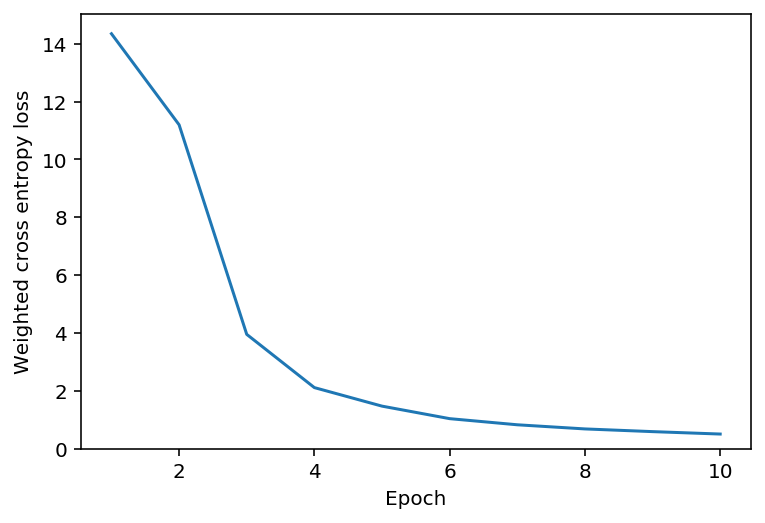

In [122]:
plt.plot(range(1,epochs+1), loss_list[num_batches-1::num_batches])
plt.xlabel('Epoch')
plt.ylabel('Weighted cross entropy loss')
plt.ylim(0)
plt.show()

In [11]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 128, 128, 12)      120       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 128, 128, 32)      3488      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 2)       578       
_________________________________________________________________
activation_2 (Activation)    (None, 128, 128, 2)       0         
Total params: 4,186
Trainable params: 4,186
Non-trainable params: 0
_________________________________________________________________


### Show results

In [73]:
Nt = 20
pt_test = Particle_Tracking_Training_Data(Nt)
vid, labels, tracks = pt_test(kappa, a, IbackLevel, Nparticles, sigma_motion) 
input_vid = tf.expand_dims(vid[:,::2,::2], 3)

In [74]:
pred = model1.predict(input_vid)

In [77]:
threshold = 0.5
pred_bin = pred.copy()
pred_bin[pred_bin <= threshold] = 0
pred_bin[pred_bin > threshold] = 1

In [78]:
@interact(t=(0, Nt-1, 1))
def plotfn(t=0, show_tracks=True):
    fig = figure(1, [14, 7])
    fig.add_subplot(131)
    imshow(vid[t], origin='lower')
    if show_tracks:
        plot(tracks[t, :, 0], tracks[t, :, 1], 'rx')
    xlim(0, 255)
    ylim(0, 255)
    plt.title('Input image')
        
    fig.add_subplot(132)
    imshow(vid[t], origin='lower')
    imshow(pred_bin[t, ..., 1], origin='lower')
    plt.title('Predicted particles')
    
    fig.add_subplot(133)
    imshow(vid[t], origin='lower')
    imshow(labels[t, ..., 1], origin='lower')
    plt.title('Ground truth')

interactive(children=(IntSlider(value=0, description='t', max=19), Checkbox(value=True, description='show_trac…

# ConvLSTM2D

#### Data Generation (videos)

In [123]:
train_size = 40
val_size = 3
Nt = 10
pt_video = Particle_Tracking_Training_Data(Nt)

train_vid2, train_labels2, train_tracks2 = generate_data(train_size, pt_video, kappa, a, IbackLevel, Nparticles, sigma_motion)
val_vid2, val_labels2, val_tracks2 = generate_data(val_size, pt_video, kappa, a, IbackLevel, Nparticles, sigma_motion)

In [ ]:
batch_size = 1
epochs = 5

model2 = Sequential()
model2.add(Input((Nt,128,128,1)))
model2.add(ConvLSTM2D(12, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(16, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(ConvLSTM2D(2, kernel_size=(3, 3), padding='same', strides=(1,1), 
                     return_sequences=True,  data_format='channels_last'))
model2.add(Activation('sigmoid'))

model2.compile(optimizer='adam',
            loss=weightedLoss(keras.losses.categorical_crossentropy, [0.0039, 0.9961]),
            metrics=['accuracy', tf.keras.metrics.Precision(name='precision_1', class_id=1), 
                      tf.keras.metrics.Recall(name='recall_1', class_id=1), f1_score])

num_batches = int(train_size/batch_size)
model2.fit(train_vid2, train_labels2, steps_per_epoch=num_batches, epochs=epochs, verbose=1, 
          validation_data=(val_vid2, val_labels2))

Epoch 1/5
40/40 [==============================] - 95s 2s/step - loss: 0.0049 - accuracy: 0.9521 - precision_1: 0.0075 - recall_1: 0.2817 - f1_score: 0.0942 - val_loss: 0.0049 - val_accuracy: 0.9420 - val_precision_1: 0.0211 - val_recall_1: 0.4431 - val_f1_score: 0.0933
Epoch 2/5
16/40 [===========>..................] - ETA: 48s - loss: 0.0040 - accuracy: 0.8835 - precision_1: 0.0122 - recall_1: 0.6902 - f1_score: 0.0926

In [15]:
tf.math.reduce_sum(train_labels2[:,:,:,:,1])

<tf.Tensor: shape=(), dtype=int32, numpy=6313>

In [16]:
1-6393/(10*10*128*128)

0.9960980224609375

In [18]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, 10, 128, 128, 12)  5664      
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 10, 128, 128, 16)  16192     
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, 10, 128, 128, 2)   1304      
_________________________________________________________________
activation_3 (Activation)    (None, 10, 128, 128, 2)   0         
Total params: 23,160
Trainable params: 23,160
Non-trainable params: 0
_________________________________________________________________
